# Siren Case Study: Beginning (part2)
---
## Searching Rigth values for target model's hyper-params

In [ ]:
RUN_COLAB_CODE = True #@param {type:"boolean"}
INSTALL_SOME_LIBS = True #@param {type:"boolean"}

In [ ]:
# Installing third party dependencies
if INSTALL_SOME_LIBS:
    print("Installing required libraries...")

    old_requirements = '/content/tmp_requirements.txt'
    !pip freeze > {old_requirements}
    dependencies_list = "stats,pretrainedmodels,torchnet,xlsxwriter,gitpython,python-git,cmapy,sk-video,pytorch-model-summary,ConfigArgParse,tabulate,chart_studio,dash,dash_bootstrap_components".split(",")

    with open(old_requirements) as f:
        old_requirements_list = f.read().split("\n")
        for a_req in dependencies_list:
            found_req = False
            for old_req in old_requirements_list:
                if old_req.startswith(a_req):
                    print(f"{a_req} already installed!")
                    found_req = True
                    break
            if found_req is False:
                !pip install {a_req} -q
        pass
    !rm -f {old_requirements}
    pass

Installing required libraries...
stats already installed!
     |████████████████████████████████| 61kB 2.7MB/s 
     |████████████████████████████████| 686kB 6.7MB/s 
     |████████████████████████████████| 204kB 20.5MB/s 
     |████████████████████████████████| 153kB 3.9MB/s 
     |████████████████████████████████| 163kB 4.3MB/s 
     |████████████████████████████████| 71kB 4.1MB/s 
     |████████████████████████████████| 2.3MB 5.0MB/s 
     |████████████████████████████████| 51kB 2.6MB/s 
tabulate already installed!
     |████████████████████████████████| 71kB 3.4MB/s 
     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 1.0MB 9.1MB/s 
     |████████████████████████████████| 3.5MB 40.5MB/s 
     |████████████████████████████████| 194kB 36.7MB/s 
     |████████████████████████████████| 1.8MB 42.1MB/s 
     |████████████████████████████████| 358kB 41.7MB/s 
     |████████████████████████████████| 194kB 5.7MB/s 


In [ ]:
%matplotlib inline
from __future__ import print_function
from __future__ import division

if RUN_COLAB_CODE:


    # --------------------------------------------- #
    # Standard Library, plus some Third Party Libraries
    # --------------------------------------------- #

    DASH_TEMPLATES_LIST = ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]

    from PIL import Image
    from functools import partial
    from pprint import pprint
    from tqdm import tqdm
    from typing import Tuple, Union


    import configargparse
    import copy
    import collections
    import cProfile
    import datetime
    import functools
    import itertools
    import h5py
    import logging
    import math
    import os
    import operator
    import pickle
    import random
    import shutil
    import sys
    import re
    import tabulate 
    import time
    # import visdom


    from collections import OrderedDict
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np

    # --------------------------------------------- #
    # Data Science and Machine Learning Libraries
    # --------------------------------------------- #
    import matplotlib
    import matplotlib.pyplot as plt
    matplotlib.style.use('ggplot')
    import seaborn as sns

    import numpy as np
    import pandas as pd
    import sklearn

    from sklearn.model_selection import ParameterGrid
    from sklearn.model_selection import train_test_split

    # --------------------------------------------- #
    # Torch
    # --------------------------------------------- #
    import torch
    try:
        import torch
        import torch.nn as nn
        import torch.nn.functional as F
        import torch.optim as optim
        from torch.utils.data import DataLoader, Dataset
        # import torch.quantization
        # import torch.nn.utils.prune as prune

        from torch import nn, optim

    except Exception as err:
        print(err)
        print("torch not available!")
        pass

    from numpy import linalg as LA
    from scipy.stats import rankdata
    from collections import OrderedDict
    from torchvision import datasets, transforms
    from torch.utils.data.sampler import SubsetRandomSampler

    # --------------------------------------------- #
    # Import: torch_pruning
    # --------------------------------------------- #
    # import torch_pruning as tp


    # --------------------------------------------- #
    # Import: TorchVision
    # --------------------------------------------- #
    try:
        import torchvision
        from torchvision import datasets
        from torchvision import transforms
        from torchvision.transforms import Resize, Compose, ToTensor, CenterCrop, Normalize
        from torchvision.utils import save_image
    except:
        print("torchvision library not available!")
        pass

    # Plotly imports.
    # ----------------------------------------------- #
    import chart_studio.plotly as py
    import plotly.figure_factory as ff
    import plotly.express as px

    # --------------------------------------------- #
    # Import: skimage
    # --------------------------------------------- #
    try:
        import skimage
        import skimage.metrics as skmetrics
        from skimage.metrics import peak_signal_noise_ratio as psnr
        from skimage.metrics import structural_similarity as ssim
        from skimage.metrics import mean_squared_error
    except:
        print("skimage library not available!")
        pass

In [ ]:
n_hf = 64
n_hl = 5
w, h = 256, 256
baseline_size = (n_hf * 2 + n_hf) + (n_hf * n_hf * n_hl + n_hf * n_hl) + (n_hf + 1)

ranges_list = [np.arange(0.25, 0.65, 0.05) for _ in range(0, n_hl)]
comb_ranges = itertools.product(*ranges_list)

In [ ]:
records = []
for comb in comb_ranges:
    comb_arr = np.array(comb)
    res_tmp = comb_arr * (n_hf * n_hf)
    res_tmp.round(0)
    compress_size = (n_hf * 2 + n_hf) + (res_tmp.sum() +  n_hf * n_hl) + (n_hf + 1)
    compress_size_p = compress_size / baseline_size * 100.0
    a_record = list(comb)  + list(res_tmp) + [compress_size, compress_size_p]
    records.append(a_record)
    pass

In [ ]:
columns = [f"%_{ii}" for ii in range(1, n_hl+1)] + [f"l_{ii}" for ii in range(1, n_hl+1)] + ['tot', 'tot%']
df = pd.DataFrame(data = records, columns = columns)
df['bpp'] = df['tot'].values * 32 / (w * h)
df.head(5)

,%_1,%_2,%_3,%_4,%_5,l_1,l_2,l_3,l_4,l_5,tot,tot%,bpp
0,0.25,0.25,0.25,0.25,0.25,1024.0,1024.0,1024.0,1024.0,1024.0,5697.0,27.055136,2.781738
1,0.25,0.25,0.25,0.25,0.30,1024.0,1024.0,1024.0,1024.0,1228.8,5901.8,28.027734,2.881738
2,0.25,0.25,0.25,0.25,0.35,1024.0,1024.0,1024.0,1024.0,1433.6,6106.6,29.000332,2.981738
3,0.25,0.25,0.25,0.25,0.40,1024.0,1024.0,1024.0,1024.0,1638.4,6311.4,29.972931,3.081738
4,0.25,0.25,0.25,0.25,0.45,1024.0,1024.0,1024.0,1024.0,1843.2,6516.2,30.945529,3.181738


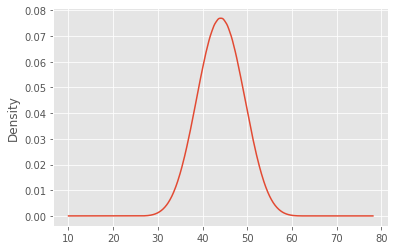

In [ ]:
df['tot%'].plot.kde()

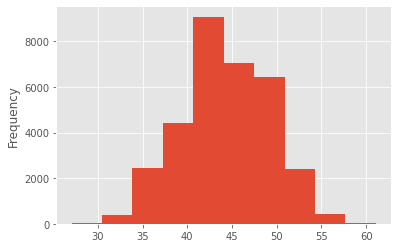

In [ ]:
df['tot%'].plot.hist()

In [ ]:
interval = df[(df['tot%'] >= 30) & (df['tot%'] < 40)]['tot%'].values.round(0).astype(dtype=np.int)

In [ ]:
collections.Counter(interval).items()

dict_items([(31, 70), (32, 126), (33, 210), (34, 330), (35, 490), (36, 690), (37, 926), (38, 1190), (39, 1470), (40, 1750)])

In [ ]:
df[(df['tot%'] >= 34) & (df['tot%'] <= 35)].sample(n=5)

,%_1,%_2,%_3,%_4,%_5,l_1,l_2,l_3,l_4,l_5,tot,tot%,bpp
4299,0.30,0.25,0.40,0.30,0.4,1228.8,1024.0,1638.4,1228.8,1638.4,7335.4,34.835922,3.581738
519,0.25,0.30,0.25,0.25,0.6,1024.0,1228.8,1024.0,1024.0,2457.6,7335.4,34.835922,3.581738
28673,0.60,0.25,0.25,0.25,0.3,2457.6,1024.0,1024.0,1024.0,1228.8,7335.4,34.835922,3.581738
617,0.25,0.30,0.30,0.50,0.3,1024.0,1228.8,1228.8,2048.0,1228.8,7335.4,34.835922,3.581738
3081,0.25,0.55,0.25,0.30,0.3,1024.0,2252.8,1024.0,1228.8,1228.8,7335.4,34.835922,3.581738


In [ ]:
df[(df['tot%'] >= 40) & (df['tot%'] <= 45)].sample(n=5)

,%_1,%_2,%_3,%_4,%_5,l_1,l_2,l_3,l_4,l_5,tot,tot%,bpp
20765,0.50,0.25,0.45,0.40,0.50,2048.0,1024.0,1843.2,1638.4,2048.0,9178.6,43.589305,4.481738
9564,0.35,0.35,0.50,0.40,0.45,1433.6,1433.6,2048.0,1638.4,1843.2,8973.8,42.616707,4.381738
3346,0.25,0.55,0.45,0.35,0.35,1024.0,2252.8,1843.2,1433.6,1433.6,8564.2,40.671511,4.181738
9593,0.35,0.35,0.50,0.60,0.30,1433.6,1433.6,2048.0,2457.6,1228.8,9178.6,43.589305,4.481738
11020,0.35,0.50,0.45,0.30,0.45,1433.6,2048.0,1843.2,1228.8,1843.2,8973.8,42.616707,4.381738


In [ ]:
df[(df['tot%'] >= 45) & (df['tot%'] <= 50)].sample(n=5)

,%_1,%_2,%_3,%_4,%_5,l_1,l_2,l_3,l_4,l_5,tot,tot%,bpp
12066,0.35,0.60,0.45,0.45,0.35,1433.6,2457.6,1843.2,1843.2,1433.6,9588.2,45.534502,4.681738
29981,0.60,0.35,0.45,0.40,0.50,2457.6,1433.6,1843.2,1638.4,2048.0,9997.8,47.479698,4.881738
17268,0.45,0.30,0.50,0.55,0.45,1843.2,1228.8,2048.0,2252.8,1843.2,9793.0,46.507100,4.781738
29476,0.60,0.30,0.45,0.45,0.45,2457.6,1228.8,1843.2,1843.2,1843.2,9793.0,46.507100,4.781738
30441,0.60,0.40,0.40,0.50,0.30,2457.6,1638.4,1638.4,2048.0,1228.8,9588.2,45.534502,4.681738


## References

#### Papers

- 1710.018778v2